In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

# Data

In [53]:
his_members = pd.read_excel("../data/members.xlsx", sheet_name=1)
his_members.head()

,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,1982-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-10-20
0,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,...,1981718D UW Equity,2061517D UW Equity,2061517D UW Equity,2150994D UW Equity,2150994D UW Equity,1950546D US Equity,2150994D UW Equity,2150994D UW Equity,A UN Equity,A UN Equity
1,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,...,2061517D UW Equity,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,AA UN Equity,AA UN Equity
2,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,...,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990253D UN Equity,9990213D UN Equity,9990253D UN Equity,A UN Equity,AAL UW Equity,AAL UW Equity
3,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,...,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990527D UW Equity,9990527D UW Equity,9990253D UN Equity,9990527D UW Equity,AA UN Equity,AAP UN Equity,AAP UN Equity
4,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,...,9990213D UN Equity,9990253D UN Equity,9990620D UN Equity,A UN Equity,A UN Equity,9990527D UW Equity,A UN Equity,AAL UW Equity,ACGL UW Equity,ACGL UW Equity


In [54]:
ave_ecoc = pd.read_excel("../clean_data/ave_ecoc_1117.xlsx", index_col=0)
FCFROIC_ADJ = pd.read_excel("../clean_data/FCFROIC_ADJ_1202.xlsx", index_col=0)
ave_ecoc.head()

,beta,name,DATES,GT10 Govt,rf,coe,10y_avg
183,1.138810,A,1994-06-30,7.319975,0.073200,0.141528,0.180326
184,1.133677,A,1994-07-29,7.110731,0.071107,0.139128,0.179694
185,1.110756,A,1994-08-31,7.173438,0.071734,0.138380,0.179047
186,1.106904,A,1994-09-30,7.603406,0.076034,0.142448,0.178495
187,1.110309,A,1994-10-31,7.806800,0.078068,0.144687,0.177961


In [55]:
ave_ecoc.index = ave_ecoc["DATES"]

In [56]:
FCFROIC_ADJ.head()

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding
0,1045,1970-06-30,1970,2.0,AAL,NaN,NaN,NaN
1,1045,1970-09-30,1970,3.0,AAL,NaN,NaN,NaN
2,1045,1970-12-31,1970,4.0,AAL,NaN,NaN,NaN
3,1045,1971-03-31,1971,1.0,AAL,NaN,NaN,NaN
4,1045,1971-06-30,1971,2.0,AAL,NaN,NaN,NaN


In [57]:
close_price = pd.read_excel("../data/stock_returns.xlsx")
close_price.head()

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return
0,ACF,1961-01-31,50.250,1961-01-31,38.000,0.322368
1,ACF,1961-02-28,50.375,1961-02-28,50.250,0.014743
2,ACF,1961-03-30,54.750,1961-03-30,50.375,0.086849
3,ACF,1961-04-28,56.000,1961-04-28,54.750,0.022831
4,ACF,1961-05-31,59.750,1961-05-31,56.000,0.078315


In [58]:
close_price["q_pre_p"] = close_price["Monthly Price"].shift(3)
close_price["q_ret"] = close_price["Monthly Price"] / \
    close_price["q_pre_p"] - 1

# classification

In [59]:
fcfroic_grouped = FCFROIC_ADJ.groupby("Data Date")

In [60]:
q_ls = his_members.columns
q_ls_d = pd.to_datetime(q_ls)

ls = []
numbers = []
high_q_rate = []
low_q_rate = []
high_q_ls = []
low_q_ls = []

for i in range(his_members.shape[1]-1):
    m = his_members.iloc[:, i].dropna()
    g = FCFROIC_ADJ[FCFROIC_ADJ["Data Date"] == m.name]

    m = m.str.extract(r'(\w+)')[0].values
    subset = g[g["Ticker Symbol"].isin(m)]
    number = subset.shape[0]
    numbers.append(number)
    subset = subset.dropna(subset=["FCFROIC_cal"])
    total_num = subset.shape[0]
    print(number, total_num)
    if subset.shape[0] > 0:
        ecoc_sub = ave_ecoc[(ave_ecoc.index >= q_ls_d[i]) & (
            ave_ecoc.index < q_ls_d[i+1])].groupby("name").mean()
        subset = subset.merge(
            ecoc_sub, left_on="Ticker Symbol", right_index=True)
        subset["10y_ind"] = 0
        subset.loc[(subset["avg_fcfroic_expanding"] >
                    subset["10y_avg"]), "10y_ind"] = 1

        high_q_n = subset["10y_ind"].sum()
        low_q_n = total_num - high_q_n
        high_q_ls.append(high_q_n)
        low_q_ls.append(low_q_n)
        high_q_rate.append(high_q_n/number)
        low_q_rate.append(low_q_n/number)

        subset["ind"] = 0
        subset.loc[(subset["FCFROIC_cal"] >
                    subset["10y_avg"]), "ind"] = 1
        ls.append(subset)

quality = pd.concat(ls, ignore_index=True)

160 0
161 0
160 0
160 0
161 0
169 0
170 0
173 0
176 0
183 0
183 0
183 0
183 0
187 0
188 0
189 0
190 0
192 0
192 0
192 0
194 0
205 0
207 0
208 0
208 0
212 0
212 0
212 0
215 5
221 6
221 8
222 31
222 45
226 54
225 69
225 151
227 156
228 167
228 167
227 167
230 167
235 168
235 169
235 169
238 171
246 176
246 177
246 177
248 180
256 180
255 181
255 182
257 185
269 187
269 188
269 190
268 196
276 198
276 200
275 204
275 207
282 204
283 208
283 212
283 213
289 213
288 213
286 213
288 219
297 219
298 222
297 221
300 227
303 225
303 226
303 229
304 234
305 238
305 240
304 239
304 240
342 284
341 284
335 279
336 311
338 306
340 308
338 307
339 309
390 348
391 350
391 350
389 348
374 329
373 330
372 331
374 373
364 363
366 365
367 367
369 369
340 340
340 340
336 334
333 333
329 329
330 330
333 332
335 335
354 353
356 355
358 357
358 357
397 395
398 396
392 391
391 390
409 409
408 408
412 412
410 410
410 409
412 410
416 415
415 413
407 405
407 404
410 408
413 411
434 432
434 432
433 433
437 436
40

In [61]:
rate = pd.DataFrame()
rate["high_num"] = high_q_ls
rate["low_num"] = low_q_ls
rate["high_q"] = high_q_rate
rate["low_q"] = low_q_rate
rate.to_excel("../clean_data/summarized_rate.xlsx")

In [63]:
quality.to_excel("../clean_data/quantity_1203.xlsx")

In [62]:
high_q = quality[quality["10y_ind"] == 1]
low_q = quality[quality["10y_ind"] == 0]

In [64]:
quality_grouped = quality.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data.xlsx")

In [65]:
quality_grouped = high_q.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data_high.xlsx")

quality_grouped = low_q.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data_low.xlsx")


In [66]:
date_idx = ave_ecoc.index.drop_duplicates()
date_idx = date_idx.sort_values()

def closest_p(dt):
    # datetime.strptime(dt, "%Y-%m-%d")
    return date_idx[date_idx >= dt][0]

## cal rolling return

In [67]:
def cal_rolling_ret(close_price):
    close_price["1y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(12).apply(np.prod, raw=True) - 1
    close_price["3y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(36).apply(np.prod, raw=True) - 1
    close_price["5y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(60).apply(np.prod, raw=True) - 1
    return close_price

In [68]:
grouped = close_price.groupby("Ticker")
ls = []
for g in grouped:
    ticker = g[0]
    g = g[1][["Monthly Price Date", "Monthly Total Return"]]
    g["Ticker"] = ticker
    g = cal_rolling_ret(g)
    ls.append(g)
rolling_ret = pd.concat(ls, ignore_index=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [69]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,1961-01-31,0.129310,A,NaN,NaN,NaN
1,1961-02-28,0.101781,A,NaN,NaN,NaN
2,1961-03-30,0.007103,A,NaN,NaN,NaN
3,1961-04-28,0.122685,A,NaN,NaN,NaN
4,1961-05-31,0.037113,A,NaN,NaN,NaN
...,...,...,...,...,...,...
656935,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN
656936,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN
656937,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN
656938,2015-08-31,0.343679,ZU,-0.458841,NaN,NaN


In [70]:
quality["close_date"] = quality["Data Date"].apply(closest_p)
close_price_u = close_price[["Monthly Price Date",
                             "Ticker", "Monthly Price", "q_ret"]]
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"],
                       right_on=["Monthly Price Date", "Ticker"], how="inner")

In [71]:
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding,beta,GT10 Govt,rf,coe,10y_avg,10y_ind,ind,close_date,Monthly Price Date,Ticker,Monthly Price,q_ret
0,1161,1994-06-30,1994,2.0,AMD,0.440928,NaN,NaN,1.622068,7.201381,0.072014,0.169338,0.202009,0,1,1994-06-30,1994-06-30,AMD,25.000,-0.200000
1,1209,1994-06-30,1994,3.0,APD,0.072844,NaN,NaN,1.232546,7.201381,0.072014,0.145967,0.156832,0,0,1994-06-30,1994-06-30,APD,42.375,-0.050420
2,1246,1994-06-30,1994,3.0,IKN,0.055781,NaN,NaN,1.034703,7.201381,0.072014,0.134096,0.148176,0,0,1994-06-30,1994-06-30,IKN,57.125,0.090692
3,1380,1994-06-30,1994,2.0,HES,0.240818,NaN,NaN,0.455329,7.201381,0.072014,0.099334,0.140378,0,1,1994-06-30,1994-06-30,HES,49.250,0.100559
4,1678,1994-06-30,1994,2.0,APA,-0.152826,NaN,NaN,0.906926,7.201381,0.072014,0.126429,0.152366,0,0,1994-06-30,1994-06-30,APA,27.625,0.194595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32129,192255,2022-03-31,2022,1.0,ACHC,0.025940,-0.010819,-0.024149,1.460231,2.340687,0.023407,0.111021,0.066162,0,0,2022-03-31,2022-03-31,ACHC,65.530,0.079572
32130,199356,2022-03-31,2022,1.0,TRIP,0.295082,0.785096,0.762940,1.320309,2.340687,0.023407,0.102625,0.115826,1,1,2022-03-31,2022-03-31,TRIP,27.120,-0.005136
32131,260774,2022-03-31,2022,1.0,CBRE,-0.162857,0.060487,0.061913,1.417245,2.340687,0.023407,0.108442,0.139234,0,0,2022-03-31,2022-03-31,CBRE,91.520,-0.156575
32132,315318,2022-03-31,2022,1.0,ESI,-0.014554,NaN,NaN,1.406285,2.340687,0.023407,0.107784,0.130204,0,0,2022-03-31,2022-03-31,ESI,21.900,-0.098023


In [60]:
quality_all.to_excel("../clean_data/quality_newnew.xlsx")

## numbers

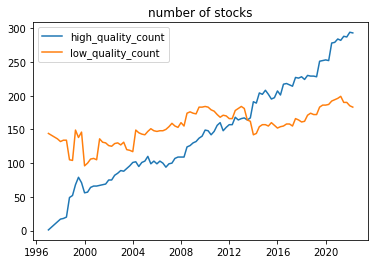

In [72]:
low_avg_count = quality_all[quality_all["10y_ind"]
                            == 0].groupby("Data Date").count()["Ticker"]
high_avg_count = quality_all[quality_all["10y_ind"] == 1].groupby("Data Date").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.title("number of stocks")
plt.savefig("../plot/avg_ret.png")

In [73]:
low_avg_ret = quality_all[quality_all["10y_ind"] == 0].groupby("Data Date").mean()[
    "q_ret"]
high_avg_ret = quality_all[quality_all["10y_ind"] == 1].groupby("Data Date").mean()[
    "q_ret"]

avg_ret = pd.merge(high_avg_ret, low_avg_ret,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_avg_ret", "low_quality_avg_ret"]
ave_ret_cum = (avg_ret + 1).cumprod()
ave_ret_cum.columns = ["high_quality_cumprod", "low_quality_cumprod"]
avg_ret_all = pd.merge(avg_ret, ave_ret_cum, left_index=True, right_index=True)
avg_ret_all.to_excel("../clean_data/avg_ret_all_1118.xlsx")

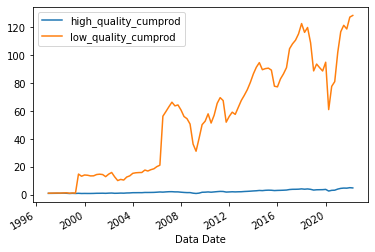

In [74]:
ave_ret_cum.plot()

In [75]:
avg_ret.merge(ave_ret_cum, left_index=True, right_index=True).to_excel("../clean_data/new_ret.xlsx")

In [76]:
ave_ret_cum

,high_quality_cumprod,low_quality_cumprod
Data Date,,
1996-12-31,0.940909,1.088410
1997-09-30,1.020144,1.198474
1997-12-31,1.018669,1.144908
1998-03-31,1.104562,1.243555
1998-06-30,1.035753,1.355786
...,...,...
2021-03-31,4.527490,116.887159
2021-06-30,4.744494,121.497753
2021-09-30,4.682766,118.866761


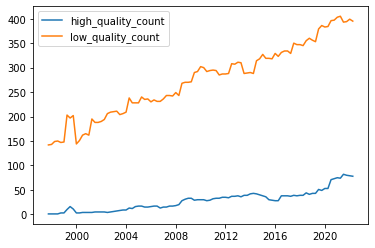

In [19]:
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.savefig("../plot/cumret.png")

In [68]:
def summary_stat(df, annual_factor, q=0.05):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    result["VaR"] = df.quantile(q)
    return result

summary_stat(avg_ret, annual_factor=4)

,mean,volatility,Sharpe Ratio,VaR
high_quality_avg_ret,0.082174,0.212375,0.386928,-0.179299
low_quality_avg_ret,0.048728,0.223495,0.218028,-0.182003


In [ ]:
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ,filtered,...,rf,coe,cost of equity,10y_avg,ind,close_date,Monthly Price Date,Ticker,q_ret_x,q_ret_y
0,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.273973,-0.273973
1,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.772727,-0.772727
2,10614,1987-12-31,1987,4.0,GL,0.225736,-0.024744,NaN,0.225736,0.225736,...,0.057656,0.117010,0.117010,0.138733,0,1987-12-31,1987-12-31,GL,-0.200000,-0.200000
3,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,0.099057,0.099057
4,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,-0.300000,-0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31958,199356,2021-12-31,2021,4.0,TRIP,0.031386,-0.052163,-0.151611,0.031386,0.031386,...,0.000507,0.083073,0.083073,0.054006,1,2021-12-31,2021-12-31,TRIP,-0.194682,-0.194682
31959,260774,2021-12-31,2021,4.0,CBRE,0.183715,0.049038,0.118106,0.183715,0.183715,...,0.000507,0.084284,0.084284,0.114787,0,2021-12-31,2021-12-31,CBRE,0.114523,0.114523
31960,315318,2021-12-31,2021,4.0,ESI,0.062421,-0.024881,-0.051197,0.062421,0.062421,...,0.000507,0.081897,0.081897,0.121450,0,2021-12-31,2021-12-31,ESI,0.119926,0.119926
31961,316056,2021-12-31,2021,4.0,ALLE,0.202411,-0.039820,-0.150675,0.202411,0.202411,...,0.000507,0.062225,0.062225,0.050331,0,2021-12-31,2021-12-31,ALLE,0.001967,0.001967


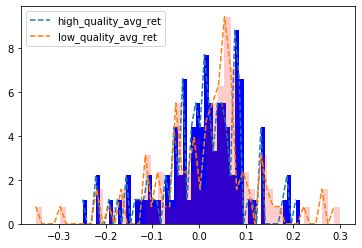

In [46]:
n1, bins1, patches1 = plt.hist(
    avg_ret.iloc[:, 0], bins=50, density=True, color='b', alpha=1)
n2, bins2, patches2 = plt.hist(
    avg_ret.iloc[:, 1], bins=50, density=True, color='r', alpha=0.2)

plt.plot(bins1[:-1], n1, '--')
plt.plot(bins2[:-1], n2, '--')
plt.legend(avg_ret.columns)

In [48]:
avg_ret.mean()/avg_ret.std()

high_quality_avg_ret    0.127573
low_quality_avg_ret     0.196831
dtype: float64

In [78]:
quality_all.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Ticker Symbol', 'FCFROIC', 'ROA', 'ROE', 'FCFROIC_ADJ', 'filtered',
       'avg_fcfroic', 'avg_fcfroic_ajd', 'beta', 'TMBIDYTM', 'rf', 'coe',
       'cost of equity', '10y_avg', '10y_ind', 'ind', 'close_date',
       'Monthly Price Date', 'Ticker', 'Monthly Price'],
      dtype='object')

In [22]:
high_q_group = quality_all[quality_all["10y_ind"] == 1].groupby("Fiscal Year")
low_q_group = quality_all[quality_all["10y_ind"] == 0].groupby("Fiscal Year")
high_dict = {}
for g in high_q_group:
    y = g[0]
    g = g[1]
    high_dict[y] = g["Ticker"].drop_duplicates()

In [23]:
close_price = close_price.drop_duplicates(
    subset=["Ticker", "Monthly Calendar Date"])
close_price.sort_values(by=["Ticker", "Monthly Calendar Date"], inplace=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [24]:
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret
8114,A,1961-01-31,49.125,1961-01-31,43.500,0.129310,23.375,1.101604
8115,A,1961-02-28,54.125,1961-02-28,49.125,0.101781,23.500,1.303191
8116,A,1961-03-30,54.000,1961-03-30,54.125,0.007103,27.000,1.000000
8117,A,1961-04-28,60.625,1961-04-28,54.000,0.122685,49.125,0.234097
8118,A,1961-05-31,62.375,1961-05-31,60.625,0.037113,54.125,0.152425
...,...,...,...,...,...,...,...,...
58488,ZU,2015-05-29,13.225,2015-05-29,12.465,0.060971,14.010,-0.056031
58489,ZU,2015-06-30,13.040,2015-06-30,13.225,-0.013989,12.990,0.003849
58490,ZU,2015-07-31,13.210,2015-07-31,13.040,0.013037,12.465,0.059767
58491,ZU,2015-08-31,17.750,2015-08-31,13.210,0.343679,13.225,0.342155


In [25]:
close_price_u = rolling_ret
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"],
                       right_on=["Monthly Price Date", "Ticker"], how="inner")
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding,beta,GT10 Govt,...,10y_avg,10y_ind,ind,close_date,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,1161,1994-06-30,1994,2.0,AMD,-0.288028,NaN,NaN,1.622068,7.201381,...,0.202009,0,0,1994-06-30,1994-06-30,-0.074074,AMD,0.036269,1.083333,1.564103
1,1209,1994-06-30,1994,3.0,APD,0.051280,NaN,NaN,1.232546,7.201381,...,0.156832,0,0,1994-06-30,1994-06-30,0.008707,APD,0.103206,0.343975,1.093011
2,1246,1994-06-30,1994,3.0,IKN,0.029201,NaN,NaN,1.034703,7.201381,...,0.148176,0,0,1994-06-30,1994-06-30,-0.015086,IKN,0.194500,0.942477,1.147874
3,1380,1994-06-30,1994,2.0,HES,0.060205,NaN,NaN,0.455329,7.201381,...,0.140378,0,0,1994-06-30,1994-06-30,-0.002005,HES,0.017765,-0.004399,0.412299
4,1678,1994-06-30,1994,2.0,APA,-0.099357,NaN,NaN,0.906926,7.201381,...,0.152366,0,0,1994-06-30,1994-06-30,0.020991,APA,0.006214,0.952022,1.487586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32127,192255,2022-03-31,2022,1.0,ACHC,0.006485,-0.002705,-0.006037,1.460231,2.340687,...,0.066162,0,0,2022-03-31,2022-03-31,0.155528,ACHC,0.146832,1.235756,0.502982
32128,199356,2022-03-31,2022,1.0,TRIP,0.073770,0.196274,0.190735,1.320309,2.340687,...,0.115826,1,0,2022-03-31,2022-03-31,0.066038,TRIP,-0.495817,-0.407879,-0.294147
32129,260774,2022-03-31,2022,1.0,CBRE,-0.037810,0.014973,0.021440,1.417245,2.340687,...,0.139234,0,0,2022-03-31,2022-03-31,-0.055034,CBRE,0.156870,0.850758,1.630641
32130,315318,2022-03-31,2022,1.0,ESI,-0.003622,NaN,NaN,1.406285,2.340687,...,0.130204,0,0,2022-03-31,2022-03-31,-0.109032,ESI,0.211757,1.208144,0.712923


In [26]:
quality_all.to_excel("../clean_data/quality_n_1202.xlsx")

In [27]:
high_q = quality_all[quality_all["10y_ind"] == 1]
low_q = quality_all[quality_all["10y_ind"] == 0]
high_q.to_excel("../clean_data/highq_bucket_1202.xlsx")
low_q.to_excel("../clean_data/lowq_bucket_1202.xlsx")

In [28]:
high_q.drop_duplicates(subset=["Fiscal Year", "Ticker"], keep="last", inplace=True)
low_q.drop_duplicates(subset=["Fiscal Year", "Ticker"], keep="last", inplace=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [29]:
rolling_ret.index = rolling_ret["Monthly Price Date"]
rolling_ret["year"] = [str(date.year) for date in rolling_ret["Monthly Price Date"]]

In [131]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret,year
Monthly Price Date,,,,,,,
1961-01-31,1961-01-31,0.129310,A,NaN,NaN,NaN,1961
1961-02-28,1961-02-28,0.101781,A,NaN,NaN,NaN,1961
1961-03-30,1961-03-30,0.007103,A,NaN,NaN,NaN,1961
1961-04-28,1961-04-28,0.122685,A,NaN,NaN,NaN,1961
1961-05-31,1961-05-31,0.037113,A,NaN,NaN,NaN,1961
...,...,...,...,...,...,...,...
2015-05-29,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN,2015
2015-06-30,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN,2015
2015-07-31,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN,2015


In [30]:
high_q_group = high_q.groupby("Fiscal Year")
ls = []
for g in high_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].drop_duplicates().values
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
high_ret_n = pd.concat(ls, ignore_index=True)

In [133]:
high_ret_n.to_excel("../clean_data/highq_bucket_rolling_is_1118.xlsx")

In [31]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.039934,0.570213,0.757100,0.719886,GL,1997
1,0.028879,0.316696,0.873837,0.776350,KRI,1997
2,0.038145,0.380926,0.868550,1.521042,LNC,1997
3,0.059142,0.768035,2.249446,6.281677,MCK,1997
4,0.033755,0.401752,1.590249,3.373513,NOC,1997
...,...,...,...,...,...,...
1997,0.039511,-0.026313,0.173823,0.192181,WTM,2022
1998,0.000516,0.077793,0.414092,0.934285,WTW,2022
1999,0.021906,-0.167031,0.153880,0.140814,WU,2022
2000,-0.039189,-0.063006,0.215658,-0.106157,XRAY,2022


In [32]:
low_q_group = low_q.groupby("Fiscal Year")
ls = []
for g in low_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].values
    high_ticker = set(high_ret_n[high_ret_n["Year"] == year].Ticker.values)
    ticker = list(set(ticker) - high_ticker)
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (
        rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
low_ret_n = pd.concat(ls, ignore_index=True)
low_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.038086,0.201086,0.185679,0.751444,ADM,1994
1,-0.012594,-0.122298,0.244863,0.168175,AFG,1994
2,0.038317,0.131518,1.323053,2.028364,AMD,1994
3,0.016049,-0.023058,-0.204805,0.127850,AN,1994
4,0.009293,0.017786,0.734398,1.295175,APA,1994
...,...,...,...,...,...,...
7154,-0.015129,0.058398,1.268986,1.582857,XPO,2022
7155,-0.032685,-0.090961,-0.234674,-0.131158,XRX,2022
7156,0.090367,0.182586,0.178523,0.206928,Y,2022
7157,0.014674,-0.206370,0.088163,0.121071,ZBH,2022


In [136]:
low_ret_n.to_excel("../clean_data/lowq_bucket_rolling_is_1118.xlsx")

In [33]:
high_ret_n.groupby("Year").mean().to_excel("../clean_data/high_rolling_is_1202.xlsx")

In [34]:
low_ret_n.groupby("Year").mean().to_excel("../clean_data/low_rolling_is_1202.xlsx")

In [35]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.039934,0.570213,0.757100,0.719886,GL,1997
1,0.028879,0.316696,0.873837,0.776350,KRI,1997
2,0.038145,0.380926,0.868550,1.521042,LNC,1997
3,0.059142,0.768035,2.249446,6.281677,MCK,1997
4,0.033755,0.401752,1.590249,3.373513,NOC,1997
...,...,...,...,...,...,...
1997,0.039511,-0.026313,0.173823,0.192181,WTM,2022
1998,0.000516,0.077793,0.414092,0.934285,WTW,2022
1999,0.021906,-0.167031,0.153880,0.140814,WU,2022
2000,-0.039189,-0.063006,0.215658,-0.106157,XRAY,2022


In [195]:
high_q_mean = high_ret_n.groupby("Year", "").mean()
low_q_mean = low_ret_n.groupby("Year").mean()
high_q_mean.to_excel("../clean_data/high_ret_is.xlsx")

In [196]:
low_q_mean.to_excel("../clean_data/low_ret_is.xlsx")